# HYDRAD Configuration Example

In [1]:
import copy
import pathlib

import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates import SkyCoord
from sunpy.coordinates import get_horizons_coord

import synthesizAR
from synthesizAR.models import semi_circular_arcade, semi_circular_bundle
from synthesizAR.interfaces.hydrad import HYDRADInterface

import pydrad.configure
import pydrad.configure.data

## Set up strand geometry

In [2]:
@u.quantity_input
def mikic_bfield_model(strand, B0=1*u.G, B1=10*u.G, ell=14*u.Mm):
    s = strand.field_aligned_coordinate
    L = strand.length
    return B0 + B1*(np.exp(-s/ell) + np.exp(-(L-s)/ell))

In [3]:
date = '2020-01-01'
view = SkyCoord(lon=20*u.deg, lat=5*u.deg, radius=1*u.Rsun, obstime=date, frame='heliographic_stonyhurst')

In [4]:
sdo = get_horizons_coord('SDO', time=date)

INFO: Obtained JPL HORIZONS location for Solar Dynamics Observatory (spacecraft) (-136395) [sunpy.coordinates.ephemeris]


In [5]:
arcade = semi_circular_bundle(100*u.Mm, 3*u.Mm, 10, inclination=5*u.deg, observer=view)
strands = [synthesizAR.Strand(f'strand{i}', s) for i,s in enumerate(arcade)]
for s in strands:
    s.field_strength = mikic_bfield_model(s, B1=25*u.G)

In [6]:
skeleton = synthesizAR.Skeleton(strands)

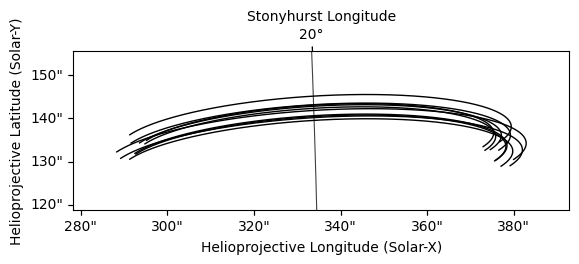

In [7]:
skeleton.peek(observer=sdo)

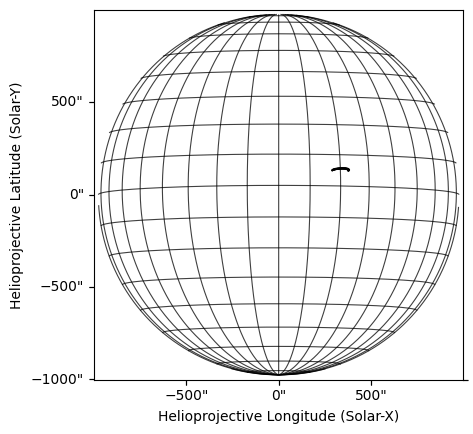

In [8]:
skeleton.peek(
    observer=sdo,
    axes_limits=((-1000,1000)*u.arcsec, (-1000,1000)*u.arcsec)
)

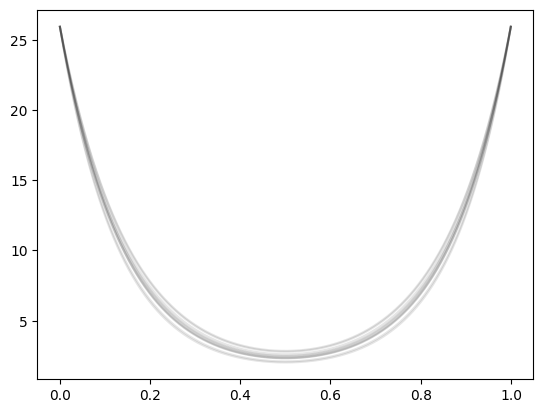

In [9]:
for s in skeleton.strands:
    plt.plot(s.field_aligned_coordinate_center_norm, s.field_strength_center, color='k', alpha=0.1)

## Configure HYDRAD Simulations

In [10]:
hydrad_path = pathlib.Path('hydrad-clean')

In [11]:
pydrad.configure.util.get_clean_hydrad(hydrad_path, from_github=True, overwrite=True)

In [13]:
default_hydrad_config = pydrad.configure.data.get_defaults()
default_hydrad_config['general']['total_time'] = 13 * u.h
default_hydrad_config['general']['output_interval'] = 6 * u.s
default_hydrad_config['general']['logging_frequency'] = 10000
default_hydrad_config['general']['write_file_equation_terms'] = False
default_hydrad_config['general']['write_file_hydrogen_level_populations'] = False
default_hydrad_config['general']['write_file_timescales'] = False
default_hydrad_config['general']['write_file_physical'] = False
default_hydrad_config['general']['write_file_ion_populations'] = True
default_hydrad_config['general']['poly_fit_gravity'] = {
    'order': 6,
    'domains': np.linspace(0,1,5),
}
default_hydrad_config['general']['poly_fit_magnetic_field'] = {
    'order': 6,
    'domains': np.linspace(0,1,5),
}
# make any modifications to defaults that will apply to all strands here
default_hydrad_config['grid']['maximum_cell_width'] = 1 * u.Mm
default_hydrad_config['grid']['maximum_cells'] = 30000
# NOTE: Setting this fairly low as we will use TRAC to deal with the refinement
default_hydrad_config['grid']['maximum_refinement_level'] = 4
default_hydrad_config['grid']['initial_refinement_level'] = 4
default_hydrad_config['grid']['linear_restriction'] = True
default_hydrad_config['grid']['enforce_conservation'] = False
default_hydrad_config['grid']['refine_on_hydrogen_energy'] = False
default_hydrad_config['grid']['adapt_every_n_time_steps'] = 10
default_hydrad_config['radiation']['decouple_ionization_state_solver'] = True
default_hydrad_config['radiation']['use_power_law_radiative_losses'] = True
default_hydrad_config['radiation']['elements_nonequilibrium'] = [
    'Fe',
	'Si',
	'Mg',
	'Ca',
	'O',
	'Ne',
]
default_hydrad_config['radiation']['rates_dataset'] = 'chianti_v10'
default_hydrad_config['initial_conditions']['footpoint_temperature'] = 1e4 * u.K
default_hydrad_config['solver']['minimum_temperature'] = 5e3 * u.K
default_hydrad_config['solver']['minimum_radiation_temperature'] = 1e4 * u.K
default_hydrad_config['solver']['safety_radiation'] = 0.01
default_hydrad_config['solver']['cutoff_temperature_fraction'] = 0.2

In [14]:
class HeatingModel:

    def calculate_event_properties(self, config, loop):
        return config

In [15]:
hydrad_interface = HYDRADInterface(
    'hydrad_results',
    base_config=default_hydrad_config,
    hydrad_dir=hydrad_path,
    use_gravity=True,
    use_magnetic_field=True,
    heating_model=HeatingModel(),
)

In [16]:
skeleton.configure_loop_simulations(hydrad_interface)

sprintf( szGravityTableFilename, "%s.table", Params.szOutputFilename );
^
/Library/Developer/CommandLineTools/SDKs/MacOSX.sdk/usr/include/stdio.h:180:1: note: 'sprintf' has been explicitly marked deprecated here
__deprecated_msg("This function is provided for compatibility reasons only.  Due to security concerns inherent in the design of sprintf(3), it is highly recommended that you use snprintf(3) instead.")
^
/Library/Developer/CommandLineTools/SDKs/MacOSX.sdk/usr/include/sys/cdefs.h:215:48: note: expanded from macro '__deprecated_msg'
        #define __deprecated_msg(_msg) __attribute__((__deprecated__(_msg)))
                                                      ^
../source/main.cpp:92:1: warning: 'sprintf' is deprecated: This function is provided for compatibility reasons only.  Due to security concerns inherent in the design of sprintf(3), it is highly recommended that you use snprintf(3) instead. [-Wdeprecated-declarations]
sprintf( szGravityFilename, "%s.gravity", Params.szOutp

INFO: 

Calculating initial hydrostatic conditions...

Peak heating range = 1.4894e-04 -> 1.4928e-04 erg cm^-3 s^-1

Optimum peak heating rate = 1.4895e-04 erg cm^-3 s^-1

Writing initial conditions file...

Done!

 [pydrad.configure.util]


In file included from ../source/mesh.h:13:
../source/eqns.h:38:31: warning: default member initializer for non-static data member is a C++11 extension [-Wc++11-extensions]
    double Tc, Te_max, old_Tc = 0.0;
                              ^
1 warning generated.
In file included from ../source/mesh.cpp:17:
In file included from ../source/mesh.h:13:
../source/eqns.h:38:31: warning: default member initializer for non-static data member is a C++11 extension [-Wc++11-extensions]
    double Tc, Te_max, old_Tc = 0.0;
                              ^
../source/mesh.cpp:203:5: warning: 'sprintf' is deprecated: This function is provided for compatibility reasons only.  Due to security concerns inherent in the design of sprintf(3), it is highly recommended that you use snprintf(3) instead. [-Wdeprecated-declarations]
    sprintf( szIonFilename, "Results/profile%i.ine", iFileNumber );
    ^
/Library/Developer/CommandLineTools/SDKs/MacOSX.sdk/usr/include/stdio.h:180:1: note: 'sprintf' has been expli

INFO: 

Calculating initial hydrostatic conditions...

Peak heating range = 1.5704e-04 -> 1.5740e-04 erg cm^-3 s^-1

Optimum peak heating rate = 1.5728e-04 erg cm^-3 s^-1

Writing initial conditions file...

Done!

 [pydrad.configure.util]


In file included from ../source/mesh.h:13:
../source/eqns.h:38:31: warning: default member initializer for non-static data member is a C++11 extension [-Wc++11-extensions]
    double Tc, Te_max, old_Tc = 0.0;
                              ^
1 warning generated.
In file included from ../source/mesh.cpp:17:
In file included from ../source/mesh.h:13:
../source/eqns.h:38:31: warning: default member initializer for non-static data member is a C++11 extension [-Wc++11-extensions]
    double Tc, Te_max, old_Tc = 0.0;
                              ^
../source/mesh.cpp:203:5: warning: 'sprintf' is deprecated: This function is provided for compatibility reasons only.  Due to security concerns inherent in the design of sprintf(3), it is highly recommended that you use snprintf(3) instead. [-Wdeprecated-declarations]
    sprintf( szIonFilename, "Results/profile%i.ine", iFileNumber );
    ^
/Library/Developer/CommandLineTools/SDKs/MacOSX.sdk/usr/include/stdio.h:180:1: note: 'sprintf' has been expli

INFO: 

Calculating initial hydrostatic conditions...

Peak heating range = 1.5382e-04 -> 1.5417e-04 erg cm^-3 s^-1

Optimum peak heating rate = 1.5385e-04 erg cm^-3 s^-1

Writing initial conditions file...

Done!

 [pydrad.configure.util]


In file included from ../source/mesh.h:13:
../source/eqns.h:38:31: warning: default member initializer for non-static data member is a C++11 extension [-Wc++11-extensions]
    double Tc, Te_max, old_Tc = 0.0;
                              ^
1 warning generated.
In file included from ../source/mesh.cpp:17:
In file included from ../source/mesh.h:13:
../source/eqns.h:38:31: warning: default member initializer for non-static data member is a C++11 extension [-Wc++11-extensions]
    double Tc, Te_max, old_Tc = 0.0;
                              ^
../source/mesh.cpp:203:5: warning: 'sprintf' is deprecated: This function is provided for compatibility reasons only.  Due to security concerns inherent in the design of sprintf(3), it is highly recommended that you use snprintf(3) instead. [-Wdeprecated-declarations]
    sprintf( szIonFilename, "Results/profile%i.ine", iFileNumber );
    ^
/Library/Developer/CommandLineTools/SDKs/MacOSX.sdk/usr/include/stdio.h:180:1: note: 'sprintf' has been expli

INFO: 

Calculating initial hydrostatic conditions...

Peak heating range = 1.6444e-04 -> 1.6482e-04 erg cm^-3 s^-1

Optimum peak heating rate = 1.6455e-04 erg cm^-3 s^-1

Writing initial conditions file...

Done!

 [pydrad.configure.util]


In file included from ../source/mesh.h:13:
../source/eqns.h:38:31: warning: default member initializer for non-static data member is a C++11 extension [-Wc++11-extensions]
    double Tc, Te_max, old_Tc = 0.0;
                              ^
1 warning generated.
In file included from ../source/mesh.cpp:17:
In file included from ../source/mesh.h:13:
../source/eqns.h:38:31: warning: default member initializer for non-static data member is a C++11 extension [-Wc++11-extensions]
    double Tc, Te_max, old_Tc = 0.0;
                              ^
../source/mesh.cpp:203:5: warning: 'sprintf' is deprecated: This function is provided for compatibility reasons only.  Due to security concerns inherent in the design of sprintf(3), it is highly recommended that you use snprintf(3) instead. [-Wdeprecated-declarations]
    sprintf( szIonFilename, "Results/profile%i.ine", iFileNumber );
    ^
/Library/Developer/CommandLineTools/SDKs/MacOSX.sdk/usr/include/stdio.h:180:1: note: 'sprintf' has been expli

INFO: 

Calculating initial hydrostatic conditions...

Peak heating range = 1.6255e-04 -> 1.6293e-04 erg cm^-3 s^-1

Optimum peak heating rate = 1.6268e-04 erg cm^-3 s^-1

Writing initial conditions file...

Done!

 [pydrad.configure.util]


In file included from ../source/mesh.h:13:
../source/eqns.h:38:31: warning: default member initializer for non-static data member is a C++11 extension [-Wc++11-extensions]
    double Tc, Te_max, old_Tc = 0.0;
                              ^
1 warning generated.
In file included from ../source/mesh.cpp:17:
In file included from ../source/mesh.h:13:
../source/eqns.h:38:31: warning: default member initializer for non-static data member is a C++11 extension [-Wc++11-extensions]
    double Tc, Te_max, old_Tc = 0.0;
                              ^
../source/mesh.cpp:203:5: warning: 'sprintf' is deprecated: This function is provided for compatibility reasons only.  Due to security concerns inherent in the design of sprintf(3), it is highly recommended that you use snprintf(3) instead. [-Wdeprecated-declarations]
    sprintf( szIonFilename, "Results/profile%i.ine", iFileNumber );
    ^
/Library/Developer/CommandLineTools/SDKs/MacOSX.sdk/usr/include/stdio.h:180:1: note: 'sprintf' has been expli

INFO: 

Calculating initial hydrostatic conditions...

Peak heating range = 1.3709e-04 -> 1.3740e-04 erg cm^-3 s^-1

Optimum peak heating rate = 1.3720e-04 erg cm^-3 s^-1

Writing initial conditions file...

Done!

 [pydrad.configure.util]


In file included from ../source/mesh.h:13:
../source/eqns.h:38:31: warning: default member initializer for non-static data member is a C++11 extension [-Wc++11-extensions]
    double Tc, Te_max, old_Tc = 0.0;
                              ^
1 warning generated.
In file included from ../source/mesh.cpp:17:
In file included from ../source/mesh.h:13:
../source/eqns.h:38:31: warning: default member initializer for non-static data member is a C++11 extension [-Wc++11-extensions]
    double Tc, Te_max, old_Tc = 0.0;
                              ^
../source/mesh.cpp:203:5: warning: 'sprintf' is deprecated: This function is provided for compatibility reasons only.  Due to security concerns inherent in the design of sprintf(3), it is highly recommended that you use snprintf(3) instead. [-Wdeprecated-declarations]
    sprintf( szIonFilename, "Results/profile%i.ine", iFileNumber );
    ^
/Library/Developer/CommandLineTools/SDKs/MacOSX.sdk/usr/include/stdio.h:180:1: note: 'sprintf' has been expli

INFO: 

Calculating initial hydrostatic conditions...

Peak heating range = 1.3996e-04 -> 1.4028e-04 erg cm^-3 s^-1

Optimum peak heating rate = 1.3997e-04 erg cm^-3 s^-1

Writing initial conditions file...

Done!

 [pydrad.configure.util]


In file included from ../source/mesh.h:13:
../source/eqns.h:38:31: warning: default member initializer for non-static data member is a C++11 extension [-Wc++11-extensions]
    double Tc, Te_max, old_Tc = 0.0;
                              ^
1 warning generated.
In file included from ../source/mesh.cpp:17:
In file included from ../source/mesh.h:13:
../source/eqns.h:38:31: warning: default member initializer for non-static data member is a C++11 extension [-Wc++11-extensions]
    double Tc, Te_max, old_Tc = 0.0;
                              ^
../source/mesh.cpp:203:5: warning: 'sprintf' is deprecated: This function is provided for compatibility reasons only.  Due to security concerns inherent in the design of sprintf(3), it is highly recommended that you use snprintf(3) instead. [-Wdeprecated-declarations]
    sprintf( szIonFilename, "Results/profile%i.ine", iFileNumber );
    ^
/Library/Developer/CommandLineTools/SDKs/MacOSX.sdk/usr/include/stdio.h:180:1: note: 'sprintf' has been expli

INFO: 

Calculating initial hydrostatic conditions...

Peak heating range = 1.5205e-04 -> 1.5241e-04 erg cm^-3 s^-1

Optimum peak heating rate = 1.5218e-04 erg cm^-3 s^-1

Writing initial conditions file...

Done!

 [pydrad.configure.util]


In file included from ../source/mesh.h:13:
../source/eqns.h:38:31: warning: default member initializer for non-static data member is a C++11 extension [-Wc++11-extensions]
    double Tc, Te_max, old_Tc = 0.0;
                              ^
1 warning generated.
In file included from ../source/mesh.cpp:17:
In file included from ../source/mesh.h:13:
../source/eqns.h:38:31: warning: default member initializer for non-static data member is a C++11 extension [-Wc++11-extensions]
    double Tc, Te_max, old_Tc = 0.0;
                              ^
../source/mesh.cpp:203:5: warning: 'sprintf' is deprecated: This function is provided for compatibility reasons only.  Due to security concerns inherent in the design of sprintf(3), it is highly recommended that you use snprintf(3) instead. [-Wdeprecated-declarations]
    sprintf( szIonFilename, "Results/profile%i.ine", iFileNumber );
    ^
/Library/Developer/CommandLineTools/SDKs/MacOSX.sdk/usr/include/stdio.h:180:1: note: 'sprintf' has been expli

INFO: 

Calculating initial hydrostatic conditions...

Peak heating range = 1.4894e-04 -> 1.4928e-04 erg cm^-3 s^-1

Optimum peak heating rate = 1.4895e-04 erg cm^-3 s^-1

Writing initial conditions file...

Done!

 [pydrad.configure.util]


In file included from ../source/mesh.h:13:
../source/eqns.h:38:31: warning: default member initializer for non-static data member is a C++11 extension [-Wc++11-extensions]
    double Tc, Te_max, old_Tc = 0.0;
                              ^
1 warning generated.
In file included from ../source/mesh.cpp:17:
In file included from ../source/mesh.h:13:
../source/eqns.h:38:31: warning: default member initializer for non-static data member is a C++11 extension [-Wc++11-extensions]
    double Tc, Te_max, old_Tc = 0.0;
                              ^
../source/mesh.cpp:203:5: warning: 'sprintf' is deprecated: This function is provided for compatibility reasons only.  Due to security concerns inherent in the design of sprintf(3), it is highly recommended that you use snprintf(3) instead. [-Wdeprecated-declarations]
    sprintf( szIonFilename, "Results/profile%i.ine", iFileNumber );
    ^
/Library/Developer/CommandLineTools/SDKs/MacOSX.sdk/usr/include/stdio.h:180:1: note: 'sprintf' has been expli

INFO: 

Calculating initial hydrostatic conditions...

Peak heating range = 1.4723e-04 -> 1.4757e-04 erg cm^-3 s^-1

Optimum peak heating rate = 1.4738e-04 erg cm^-3 s^-1

Writing initial conditions file...

Done!

 [pydrad.configure.util]


In file included from ../source/mesh.h:13:
../source/eqns.h:38:31: warning: default member initializer for non-static data member is a C++11 extension [-Wc++11-extensions]
    double Tc, Te_max, old_Tc = 0.0;
                              ^
1 warning generated.
In file included from ../source/mesh.cpp:17:
In file included from ../source/mesh.h:13:
../source/eqns.h:38:31: warning: default member initializer for non-static data member is a C++11 extension [-Wc++11-extensions]
    double Tc, Te_max, old_Tc = 0.0;
                              ^
../source/mesh.cpp:203:5: warning: 'sprintf' is deprecated: This function is provided for compatibility reasons only.  Due to security concerns inherent in the design of sprintf(3), it is highly recommended that you use snprintf(3) instead. [-Wdeprecated-declarations]
    sprintf( szIonFilename, "Results/profile%i.ine", iFileNumber );
    ^
/Library/Developer/CommandLineTools/SDKs/MacOSX.sdk/usr/include/stdio.h:180:1: note: 'sprintf' has been expli

In [19]:
s = pydrad.parse.Strand('hydrad_results/strand0/', read_trm=False)

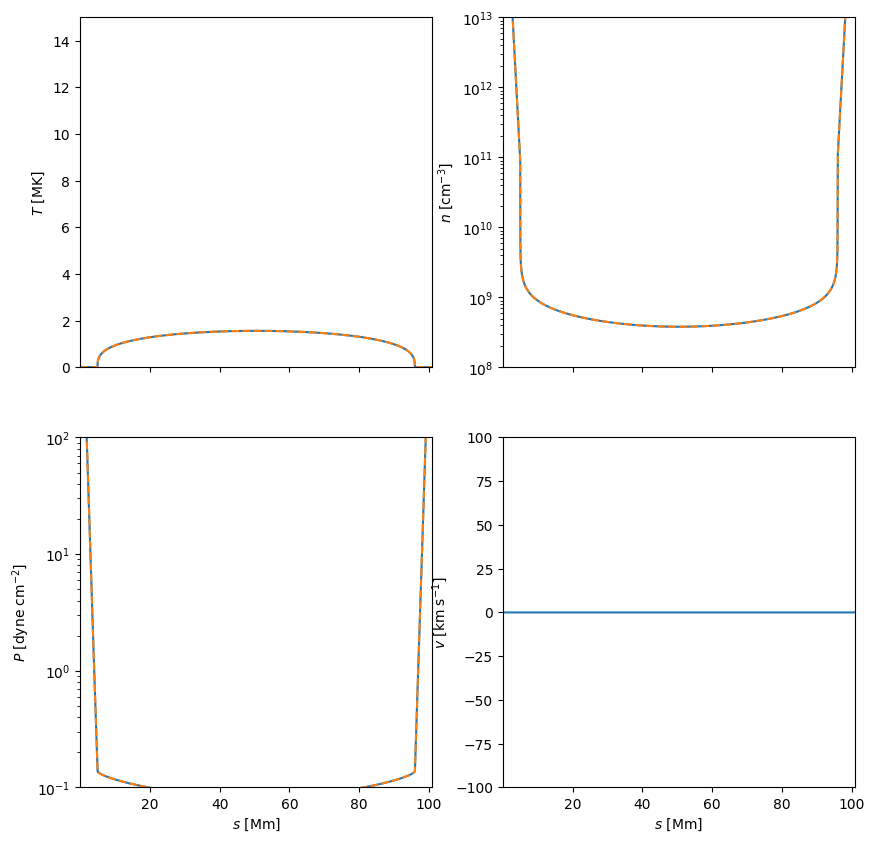

In [21]:
s.initial_conditions.peek()